In [1]:
import logging
import numpy as np

from apsopt.core.optimizer import Optimizer, get_generator_class
from apsopt.core.evaluators import FunctionEvaluator
from apsopt.util.pydantic.options import AlgorithmOptions
from apsopt.util.pydantic.vocs import GVOCS

from opt_funcs_nsls import make_dummy_eval

logger = logging.getLogger(__name__)

SETUP

In [2]:
variables = {'x0':[0,1], # magnet current/knob/etc.
              'x1':[0,1]}
objectives = {'LT':'maximize', 'EFF':'maximize'}
reference_point = {'LT':0.7, # hours
                   'EFF':0.5 # fraction injected
                   }
initial_variable_values = {'x0':0.1, 'x1':0.1}

gvocs = GVOCS(variables=variables,
              variables_active=variables,
              objectives=objectives,
              objectives_active=objectives)

In [3]:
eval_f = make_dummy_eval(gvocs)
ev = FunctionEvaluator(script=eval_f)

generator_name = 'aps_mobo'
gc = get_generator_class(generator_name)

gen = gc(gvocs=gvocs)
gen.numerical_optimizer.n_raw_samples = 512
gen.numerical_optimizer.n_restarts = 10
gen.gp_constructor.use_low_noise_prior = False
gen.gp_constructor.use_high_noise_prior = False
#gen.max_travel_distances = [0.1] * len(gvocs.variables_active)
gen.reference_point = reference_point

In [4]:
options = AlgorithmOptions(store_history=True, dump_every_step=True)
opt = Optimizer(options=options,
                generator=gen,
                evaluator=ev,
                gvocs=gvocs)

Sample at initial values (i.e. standard lattice)

In [5]:
opt.generate_at(initial_variable_values)
opt.evaluate_data()

In [6]:
opt.data

,x0,x1,result,exception,traceback,wall_time,cpu_time,valid,LT,EFF
1,0.1,0.1,"{'LT': 8.480386934123942, 'EFF': 0.19450885330...",None,,0.00007,0.0,True,8.480387,0.194509


Sample close to initial point

In [7]:
mt = {'x0':0.05, 'x1':0.05}
opt.generate_random_around_point(n=1, point=initial_variable_values, spans=mt, use_normalized_distances=True)
opt.evaluate_data()

In [8]:
opt.data

,x0,x1,result,exception,traceback,wall_time,cpu_time,valid,LT,EFF
1,0.100000,0.10000,"{'LT': 8.480386934123942, 'EFF': 0.19450885330...",None,,0.000070,0.0,True,8.480387,0.194509
2,0.092932,0.11629,"{'LT': 9.075438899276502, 'EFF': 0.25808552853...",None,,0.000078,0.0,True,9.075439,0.258086


Run optimizer

In [9]:
import warnings
#warnings.filterwarnings("ignore", message="Unable to find non-zero acquisition function values")

for i in range(20):
    opt.step()

c:\Users\boss\Anaconda3\envs\py311ml\Lib\site-packages\botorch\optim\initializers.py:404: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


In [10]:
opt.state_to_json()

'{\n  "optimizer": {\n    "tag": "ff2703efa6",\n    "store_history": true,\n    "dump_every_step": true,\n    "history_directory": null,\n    "execution_mode": "sync"\n  },\n  "generator": {\n    "name": "aps_mobo",\n    "n_monte_carlo_samples": 128,\n    "turbo_controller": null,\n    "use_cuda": false,\n    "gp_constructor": {\n      "name": "mobo_model",\n      "use_low_noise_prior": false,\n      "covar_modules": {},\n      "mean_modules": {},\n      "trainable_mean_keys": [],\n      "use_high_noise_prior": false\n    },\n    "numerical_optimizer": {\n      "name": "APSLBFGS",\n      "n_raw_samples": 512,\n      "n_restarts": 10,\n      "max_iter": 2000,\n      "sequential": true\n    },\n    "max_travel_distances": null,\n    "fixed_features": null,\n    "computation_time": null,\n    "n_candidates": 1,\n    "reference_point": {\n      "LT": 0.7,\n      "EFF": 0.5\n    },\n    "prune_inferior_points_kwargs": null\n  },\n  "evaluator": {\n    "name": "func",\n    "on_error": "ignor

In [11]:
opt.data.tail()

,x0,x1,result,exception,traceback,wall_time,cpu_time,valid,LT,EFF
18,0.564370,0.355658,"{'LT': 9.963702429513738, 'EFF': 0.96705414890...",None,,0.000048,0.0,True,9.963702,0.967054
19,0.644942,0.449966,"{'LT': 9.678292594548425, 'EFF': 1.10438014509...",None,,0.000055,0.0,True,9.678293,1.104380
20,0.723798,0.823684,"{'LT': 8.840961144835909, 'EFF': 1.52457172241...",None,,0.000060,0.0,True,8.840961,1.524572
21,0.666315,0.635074,"{'LT': 9.201718014835347, 'EFF': 1.39703864168...",None,,0.000053,0.0,True,9.201718,1.397039
22,0.453318,0.430445,"{'LT': 10.019104151065168, 'EFF': 0.9245651224...",None,,0.000051,0.0,True,10.019104,0.924565


Text(0, 0.5, 'Hypervolume')

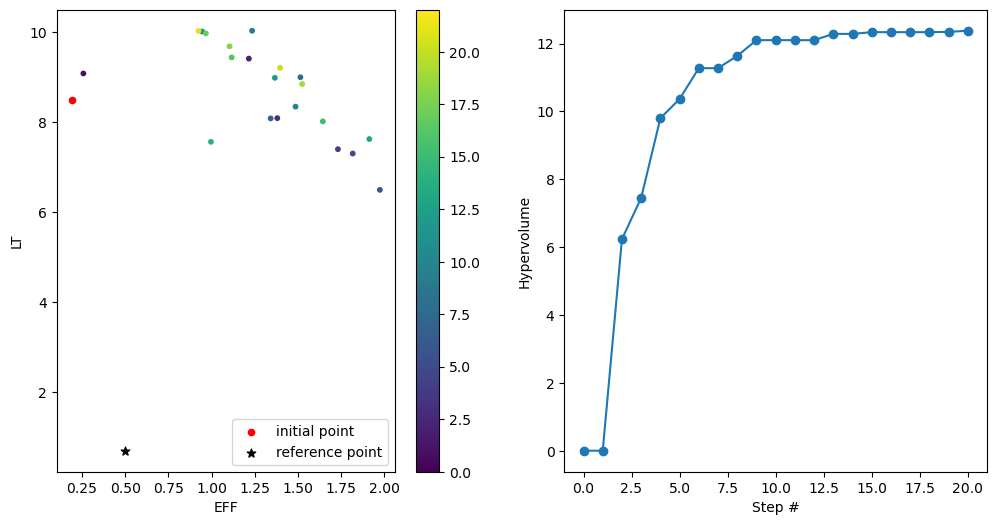

In [12]:
import matplotlib.pyplot as plt

hvs = []
for i in range(1,len(opt.data)):
    hv = opt.generator.calculate_hypervolume_at(i)
    hvs.append(hv)

fig,ax = plt.subplots(1,2,squeeze=False,figsize=(12,6))
df = opt.data
ol = ['EFF', 'LT']
l = ax[0,0].scatter(df.loc[:,ol[0]], df.loc[:,ol[1]],10,marker='o',c=range(len(df)),vmax=len(df))
ax[0,0].scatter(df.loc[:1,ol[0]], df.loc[:1,ol[1]], 20,marker='o',c='red',label='initial point')
ax[0,0].scatter(gen.reference_point[ol[0]], gen.reference_point[ol[1]],40,marker='*',c='black',label='reference point')
ax[0,0].set_xlabel(ol[0])
ax[0,0].set_ylabel(ol[1])
fig.colorbar(l)
ax[0,0].legend()

ax[0,1].plot(hvs,marker='o')
ax[0,1].set_xlabel('Step #')
ax[0,1].set_ylabel('Hypervolume')

In [ ]:
# This will save optimizer state
opt.state_to_json('mobo_dump.json')

import os
os.remove('mobo_dump.json')